In [1]:
from functools import partial
from io import BytesIO
from itertools import islice
import json
import os
import math
import re
import subprocess

from IPython import display
import ipywidgets as widgets
from imageio import imwrite
from ipywidgets import interact
from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.io import wavfile
from scipy.ndimage import convolve, generate_binary_structure
from scipy.ndimage.filters import laplace
from scipy.signal import get_window
from tqdm import tqdm_notebook

![Both Kinds!](img/both_kinds.png)

# Fast Fourier Transforms

[![Think DSP](http://greenteapress.com/wp/wp-content/uploads/2016/01/think_dsp_cover-229x300.jpg)](http://greenteapress.com/wp/think-dsp/)

In [2]:
def pulse_wave(period, width, N, samples=128):
    pw = width / period
    wave = np.zeros((N+1, samples))
    t = 2.0*np.pi * np.linspace(0.0, 2*np.pi, samples) / period
    for i in range(N-1):
        n = i+1
        wave[i,:] = 2.0/(n*np.pi) * np.sin(np.pi*n*pw) * np.cos(n*t)
    wave[N-1,:] = pw + wave[0:N-1,:].sum(axis=0)
    return wave

def plot_pulse_wave(period, pulse_width, harmonics):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    width = pulse_width * period
    t = np.linspace(0.0, 2*np.pi, 512)
    wave = pulse_wave(period, width, harmonics, 512)
    for i in range(harmonics-1):
        plt.plot(t, wave[i], color='blue')
    plt.plot(t, wave[harmonics-1], color='green', linewidth=2)

# [Pulse Waves](https://en.wikipedia.org/wiki/Pulse_wave)

$$\Large{\textrm{At time t for period T and duty-cycle $\tau$:}
\\f(t) = \frac{\tau}{T} + \sum_{n=1}^{\infty}\frac{2}{n\pi}sin\left(\frac{\pi n\tau}{T}\right)
cos\left(\frac{2\pi n t}{T} \right)}$$


In [3]:
interact(plot_pulse_wave,
    period = widgets.FloatSlider(min=0.5, max=6.0, value=3.0, step=0.5, description='period'),
    pulse_width = widgets.FloatSlider(min=0.1, max=0.99, value=0.5, step=0.1, description='duty-cycle'),
    harmonics = widgets.IntSlider(min=1, max=50, value=8, step=1, description='harmonics'))

interactive(children=(FloatSlider(value=3.0, description='period', max=6.0, min=0.5, step=0.5), FloatSlider(va…

<function __main__.plot_pulse_wave(period, pulse_width, harmonics)>

# [The Gauss Map](https://en.wikipedia.org/wiki/Gauss_iterated_map)
$$\Huge{x_{n+1} = e^{(-\alpha x_{n}^2)}+\beta}$$

In [4]:
def gauss_map(x,alpha,beta):
    while True:
        yield x
        x = math.exp(-alpha*x*x) + beta
        
def gauss_hist(beta,alpha,n,count,skip):
    gm = gauss_map(0.01,alpha,beta)
    hist = np.histogram(list(islice(gm,skip,skip+count)),n,(-1.5,1.5))[0]
    scale = 1.0 / np.max(hist)
    return hist * scale

def plot_gauss_hist(alpha,beta):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    plt.plot(gauss_hist(beta, alpha, 720, 512, 4096), color='green')
    plt.show()

In [5]:
interact(plot_gauss_hist, alpha=widgets.FloatSlider(min=1.0,max=9.75, value=4.0, step=0.5, description=r'\(\Large{\alpha}\)'),
    beta=widgets.FloatSlider(min=-1.0,max=1.0, value=-0.5, step=0.05, description=r'\(\Large{\beta}\)'))

interactive(children=(FloatSlider(value=4.0, description='\\(\\Large{\\alpha}\\)', max=9.75, min=1.0, step=0.5…

<function __main__.plot_gauss_hist(alpha, beta)>

In [6]:
def gauss_image(alpha, beta_min, beta_max, width, height):
    img = np.zeros(shape=(height, width,3))
    gh = partial(gauss_hist, alpha=alpha, n=height, count=512, skip=4096)
    img[:,:,1] = np.array(list(map(gh, np.linspace(beta_min, beta_max, width)))).T
    img = 255 * img / img.max()
    return img.astype(np.uint8)

def plot_gauss_image(alpha):
    im_bytes = BytesIO()
    imwrite(im_bytes, gauss_image(alpha, -1.0, 1.0, 600, 480), format='png')
    return display.display(display.Image(data=im_bytes.getvalue()))

def segment(hist, n, win):
    return np.multiply(np.real(np.fft.irfft(hist, n=n)), win)

In [7]:
interact(plot_gauss_image, alpha=widgets.FloatSlider(min=1.0,max=9.75, value=5.0, step=0.5, description=r'\(\Large{\alpha}\)'))

interactive(children=(FloatSlider(value=5.0, description='\\(\\Large{\\alpha}\\)', max=9.75, min=1.0, step=0.5…

<function __main__.plot_gauss_image(alpha)>

Text(0, 0.5, 'windowed signal')

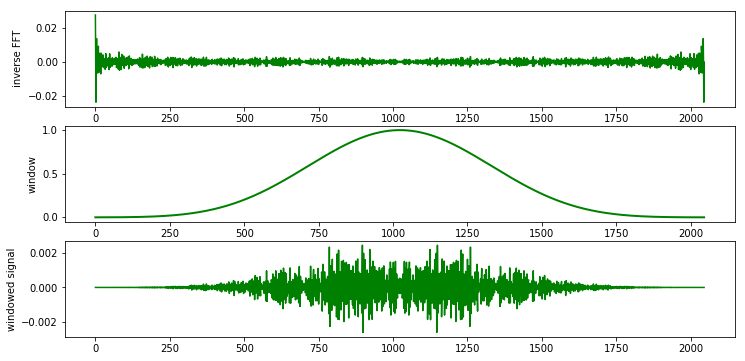

In [8]:
# Example of a windowed IFFT.
%matplotlib inline
N = 1024
window = get_window('blackmanharris',2*(N-1))
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(12, 6)
axs[0].plot(np.real(np.fft.irfft(gauss_hist(-0.6, 9.0, 1024, 512, 409), n=2046)), color='green')
axs[0].set_ylabel('inverse FFT')
axs[1].plot(window, color='green', linewidth=2)
axs[1].set_ylabel('window')
axs[2].plot(segment(gauss_hist(-0.6,9.0,1024,512,409),2046,window), color='green')
axs[2].set_ylabel('windowed signal')

![the first thing to do would be to consider time as offically ended](img/time_officially_ended.png)

In [9]:
def scan(alpha_min,alpha_max,alpha_count,beta_min,beta_max,beta_count):
    d_alpha = (alpha_max - alpha_min) / alpha_count
    d_beta = (beta_max - beta_min) / beta_count
    beta = beta_min
    for i in range(alpha_count):
        alpha = alpha_min + d_alpha * i
        if i % 2 == 1:
            db = -d_beta
        else:
            db = d_beta
        for j in range(beta_count):
            yield(alpha, beta)
            beta += db

            
def frame_count(dur, N, H, bias, rate=44100):
    frames = dur * rate
    segments = int(frames / H)
    alpha_count = int(bias * np.sqrt(segments))
    beta_count = int(segments / alpha_count)
    segments = alpha_count * beta_count
    frames = 2 * (N-1) + segments * H
    return frames, alpha_count, beta_count


def build_frames(dur, N, n, H, bias, alpha_min=1.0, alpha_max=9.75, beta_min=-0.95, beta_max=0.5, rate=44100):
    pan_range = np.arange(N)
    frames, alpha_count, beta_count = frame_count(dur,n,H,bias,rate)
    pan = np.zeros(alpha_count * beta_count)
    output = np.zeros(frames,dtype=np.float32)
    window = get_window('blackmanharris',n)
    hist_count = 4 * N
    with tqdm_notebook(range(alpha_count*beta_count), desc='building audio', leave=True) as bar:
        for i, pars in enumerate(scan(alpha_min ,alpha_max, alpha_count, beta_min , beta_max, beta_count)):
            alpha, beta = pars
            hist = gauss_hist(beta,alpha,N,hist_count,N)
            pan[i] = np.average(pan_range, weights=hist) / N
            seg = segment(hist,n,window)
            start = i * H
            end = start + n
            output[start:end] += seg
            bar.update(1)
    return output, pan


In [10]:
def dump_mono(data,fname,rate=44100):
    scale = 32767.0 / np.max(data) 
    buff = scale * data
    wavfile.write(fname, rate, buff.astype(np.int16))
    
def dump_stereo(data, pan, H, depth, fname, reverse=True, rate=44100):
    scale = 32767.0 / np.max(data)
    floor = 1.0 - depth
    f = UnivariateSpline(np.arange(0,len(data),H)[0:len(pan)], pan)
    pan_interp = depth * f(np.arange(len(data)))
    output = np.zeros((len(data),2))
    output[:,0] = scale * (floor + pan_interp) * data
    if reverse:
        output[::-1,1] = scale * (1.0 - pan_interp) * data
    else:
        output[:,1] = scale * (1.0 - pan_interp) * data   
    wavfile.write(fname, rate, output.astype(np.int16))

In [11]:
def write_frames(path, prefix, frames, alpha_min=1.0, alpha_max=9.75, beta_min=-0.95, beta_max=0.5,
    width=1280, height=720):
    if not os.path.exists(path):
        os.makedirs(path)
    d_alpha = (alpha_max - alpha_min) / frames
    for i in tqdm_notebook(range(frames), desc='building video'):
        alpha = alpha_min + i * d_alpha
        fname = path + '/' + prefix + ('000000'+str(i))[-6:] + '.png'
        img = gauss_image(alpha, beta_min, beta_max, width, height)
        imwrite(fname, img, format='png')



In [12]:
name_box = widgets.Text(value='gauss_map', placeholder='enter a filename', description='filename')
dur_slider = widgets.IntSlider(min=10, max=600, value=240, step=5, description='duration (s)')
sample_slider = widgets.IntSlider(min=8, max=14, value=10, step=1, description='samples')
fft_slider = widgets.IntSlider(min=8, max=20, value=16, step=1, description='FFT size')
hop_slider = widgets.IntSlider(min=7, max=14, value=11, step=1, description='hop size')
bias_slider = widgets.FloatSlider(min=0.1, max=1.5, value=0.25, step=1, description='bias')
build_video = widgets.RadioButtons(options=['off', 'on'], value='off', description='build video')
build_button = widgets.Button(description='Build')

def build_gaussmap(b):
    fname = name_box.value
    dur = dur_slider.value
    N = 2**sample_slider.value
    n = 2**fft_slider.value
    H = 2**hop_slider.value
    bias = bias_slider.value
    
    if build_video.value == 'on':
        video = True
        rate = 48000
    else:
        video = False
        rate = 44100
    
    output, pan = build_frames(dur, N, n+N, H, bias, rate=rate)
    
    for direc in ('audio', 'frames', 'video'):
        if not os.path.exists(direc):
            os.makedirs(direc)
    audio_file = '/'.join(['audio', '{}.wav'.format(fname)])

    output = dump_stereo(output, pan, H, 0.5, audio_file, reverse=True, rate=rate)
    
    if video:
        frames = 24 * dur
        frame_path = '/'.join(['frames', fname])
        write_frames(frame_path, 'gauss_', frames)
        video_file = '/'.join(['video', '{}.mp4'.format(fname)])
        
        args = ['ffmpeg', '-i', '{}/gauss_%06d.png'.format(frame_path), '-i',
            audio_file, '-c:v', 'libx264', '-acodec', 'libmp3lame', '-r', '24',
            '-pix_fmt', 'yuv420p', video_file]
        
        subprocess.run(args)

    display.display(display.Audio(filename=audio_file))
    
    if video:
        display.display(widgets.Video.from_file(video_file))

build_button.on_click(build_gaussmap)

In [13]:
for wdgt in (name_box, dur_slider, sample_slider, fft_slider, hop_slider, bias_slider, build_video,
    build_button):
    display.display(wdgt)

Text(value='gauss_map', description='filename', placeholder='enter a filename')

IntSlider(value=240, description='duration (s)', max=600, min=10, step=5)

IntSlider(value=10, description='samples', max=14, min=8)

IntSlider(value=16, description='FFT size', max=20, min=8)

IntSlider(value=11, description='hop size', max=14, min=7)

FloatSlider(value=0.25, description='bias', max=1.5, min=0.1, step=1.0)

RadioButtons(description='build video', options=('off', 'on'), value='off')

Button(description='Build', style=ButtonStyle())

In [14]:
def el_ca_rule(r):
    return np.array([1 if (r & 2**i) else 0 for i in range(8)], dtype=np.int16)


def apply_rule(rule, row):
    left = np.roll(row, -1)
    right = np.roll(row, 1)
    index = 4 * left + 2 * row + right
    return rule[index]


def el_ca_stream(rule_num, width):
    rule = el_ca_rule(rule_num)
    row = np.zeros(width, dtype=np.int16)
    row[width//2] = 1
    while True:
        yield row
        row = apply_rule(rule, row)

In [15]:
def green_image(cells):
    height, width = cells.shape
    img = np.zeros(shape=(height, width,3))
    img[:,:,1] = cells
    img = 255 * img / img.max()
    im_bytes = BytesIO()
    imwrite(im_bytes, img.astype(np.uint8), format='png')
    return im_bytes.getvalue()


def draw_rule(rule, width):
    r = el_ca_stream(rule,width=width)
    img = [r.__next__() for i in range(width)]
    return green_image(np.array(img, dtype=np.int16))
    

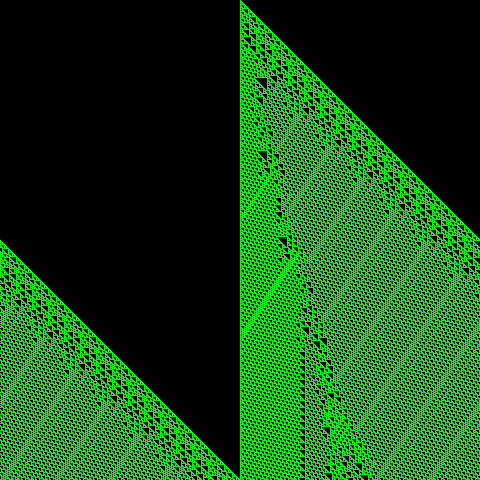

In [16]:
display.Image(draw_rule(110, 480))

In [17]:
def ca_history(rule, width, t, depth=8):
    ca = el_ca_stream(rule, width)
    hist = np.zeros([depth, width], dtype=np.int16)
    powers = np.array([[2**i] for i in range(depth)], dtype=np.int16)
    for _ in range(t):
        row = ca.__next__()
        hist = np.roll(hist, -1, axis=0)
        hist[-1] = row
        yield np.sum(hist * powers, axis=0)

In [18]:
def build_el_ca_frames(rule, width, dur, N, H, depth=8, rate=44100):
    samples = dur * rate
    segments = int(samples / H)
    frames = 2 * (N-1) + segments * H    
    window = get_window('blackmanharris', N)
    ca = ca_history(rule, width, segments, depth=depth)
    output = np.zeros(2+frames, dtype=np.float32)
    with tqdm_notebook(range(segments), desc='building audio', leave=True) as bar:
        for i, hist in enumerate(ca):
            seg = np.multiply(np.real(np.fft.irfft(hist, n=N)), window)
            start = i * H
            end = start + N
            output[start:end] += seg
            bar.update(1)
    return output

def el_ca_dump_stereo(fname, left_rule, right_rule, width, dur, N, H, depth=8, rate=44100):
    
    left = build_el_ca_frames(left_rule,width,dur,N,H,depth=depth,rate=rate)
    right = build_el_ca_frames(right_rule,width,dur,N,H,depth=depth,rate=rate)
    l_scale = 32767.0 / np.max(left)
    r_scale = 32767.0 / np.max(right)
    output = np.zeros((len(left),2))
    output[:,0] = l_scale * left
    output[:,1] = r_scale * right
        
    wavfile.write(fname, rate, output.astype(np.int16))
    


In [19]:
left_rule_slider = widgets.IntSlider(min=0, max=255, value=30, step=1, description='left rule')
right_rule_slider = widgets.IntSlider(min=0, max=255, value=86, step=1, description='right rule')
left_ca_im = widgets.Image(value=draw_rule(left_rule_slider.value, 320))
right_ca_im = widgets.Image(value=draw_rule(right_rule_slider.value, 320))
left_ca = widgets.VBox([left_rule_slider, left_ca_im])
right_ca = widgets.VBox([right_rule_slider, right_ca_im])

el_ca_bit_slider = widgets.IntSlider(min=1, max=16, value=8, step=1, description='bit-depth')
el_ca_dur_slider = widgets.IntSlider(min=10, max=600, value=120, step=5, description='duration (s)')
el_ca_width_slider = widgets.IntSlider(min=7, max=14, value=9, step=1, description='width')
el_ca_fft_slider = widgets.IntSlider(min=9, max=20, value=14, step=1, description='FFT size')
el_ca_hop_slider = widgets.IntSlider(min=7, max=12, value=11, step=1, description='hop size')
el_ca_build_button = widgets.Button(description='Build')

el_ca_fft_box = widgets.VBox([el_ca_bit_slider, el_ca_dur_slider, el_ca_width_slider,
    el_ca_fft_slider, el_ca_hop_slider, el_ca_build_button]) 

ca_box = widgets.HBox([left_ca, right_ca, el_ca_fft_box])

def set_left_box(_):
    left_ca_im.value=draw_rule(left_rule_slider.value, 320)
    
def set_right_box(_):
    right_ca_im.value=draw_rule(right_rule_slider.value, 320)    

def el_ca_sound(_):
    left_rule = left_rule_slider.value
    right_rule = right_rule_slider.value
    width = 2**el_ca_width_slider.value
    dur = el_ca_dur_slider.value
    N = 2**el_ca_fft_slider.value
    H = 2**el_ca_hop_slider.value
    depth = el_ca_bit_slider.value
    
    if not os.path.exists('audio'):
        os.makedirs('audio')    
    audio_file = '/'.join(['audio', '{}_{}.wav'.format(left_rule, right_rule)])  
    
    el_ca_dump_stereo(audio_file, left_rule, right_rule, width, dur, N, H, depth=8, rate=44100)
    
    display.display(display.Audio(filename=audio_file))
    
left_rule_slider.observe(set_left_box, names='value')
right_rule_slider.observe(set_right_box, names='value')

el_ca_build_button.on_click(el_ca_sound)

In [20]:
display.display(ca_box)

In [21]:
class Oliva(object):
    def __init__(self,width=640, skip=12, act_diff=0.015, act_decay=0.1,
        act_prod=0.1, sat=0.25, in_diff=0.0, in_decay=0.014, in_mm=0.1,
        h_decay=0.1, hormone=0.5):
         
        self.width = width
        self.cells = np.zeros((2,2,self.width))
        
        self.skip = skip
        
        self.act_diff = act_diff
        self.act_decay = act_decay
        self.act_prod = act_prod
        self.sat = sat
         
        self.in_diff = in_diff
        self.in_decay = in_decay
        self.in_mm = in_mm
        self.h_decay = h_decay
        self.h_fac = 1-self.h_decay
        self.hormone = hormone
        
        self.tick = False
         
        self.cells[0,1,:] = 0.1
         
        self.fluct = self.act_decay * (0.96 +
            0.08 *np.random.random(self.width))
            
        seeds = np.random.choice(np.arange(self.width),30,replace=False)
        self.cells[0,0,seeds] = 1.0
        
        self.act_diff_const = 1.0 - self.act_decay -2*self.act_diff
        self.in_diff_const = 1.0 - self.in_decay -2*self.in_diff


    def step(self):
        if self.tick:
            old = 1
            new = 0
        else:
            old = 0
            new = 1
        
        l_bound = np.copy(self.cells[old,:,0])
        r_bound = np.copy(self.cells[old,:,-1])
                
        act_sq = np.square(self.cells[old,0,:])
        auto_cat = self.fluct * act_sq / (1 + self.sat * act_sq)
        
        left_cells = np.roll(self.cells[old,:,:],-1,axis=1)
        right_cells = np.roll(self.cells[old,:,:],1,axis=1)

        left_cells[:,0] = l_bound
        right_cells[:,-1] = r_bound
                
        self.cells[new,0,:] = self.cells[old,0,:] * self.act_diff_const + self.act_diff * (left_cells[0,:] + right_cells[0,:]) + auto_cat / (self.in_mm + self.cells[old,1,:])
            
        self.cells[new,1,:] = self.cells[old,1,:] * self.in_diff_const + self.in_diff * (left_cells[1,:] + right_cells[1,:]) + auto_cat
            
        hormone_prod = (self.cells[old,0,:] * self.h_decay).sum()
        
        self.hormone = self.hormone * self.h_fac + hormone_prod / self.width
            
        self.in_diff_const = 1.0 - 2 * self.in_diff - self.in_decay / self.hormone
        
        self.tick = not self.tick
        
        
    def __iter__(self):
        return self
    
    
    def __next__(self):
        self.step()
        if self.tick:
            out = np.copy(self.cells[0,:,:])
        else:
            out = np.copy(self.cells[1,:,:])
        for i in range(self.skip):
            self.step()
        return out

In [22]:
def left_cell(mollusc):
    mollusc.cells[0,:,0] = mollusc.init_conc[:,0]
    
    
def left_right_cell(mollusc):
    mollusc.cells[0,:,0] = mollusc.init_conc[:,0]
    mollusc.cells[0,:,-1] = mollusc.init_conc[:,0]
    
    
def central_cell(mollusc):
    mollusc.cells[0,:,mollusc.width//2] = mollusc.init_conc[:,0]
        
    
initial_conditions = {1:left_cell, 2:left_right_cell,
    3:central_cell}

In [23]:
class Mollusc(object):
    
    def argfilter(self,initial,**kwargs):
        linitial = initial.lower()
        args = filter(lambda k: len(k)==2 and k.lower().startswith(linitial), kwargs.keys())
        return np.array([[kwargs[k] for k in sorted(args)[0:self.num_vars]]]).T


    def __init__(self,width=640,**kwargs):
        self.width = width
        
        self.num_vars = kwargs['kn']
        
        self.diff_coeffs = self.argfilter('d', **kwargs)
        self.decay_rates = self.argfilter('r', **kwargs)
        self.basic_prod = self.argfilter('b', **kwargs)
        self.saturation = self.argfilter('s', **kwargs)
        self.coupling = self.argfilter('c', **kwargs)
        self.init_conc = self.argfilter('a', **kwargs)
        self.gen_conc = self.argfilter('g', **kwargs)

        self.activator_saturation = self.saturation[0]

        self.substrate = np.ones(width)

        self.decay_diff_consts = 1.0 - self.decay_rates - 2 * self.diff_coeffs

        eq_methods = {method:getattr(self, method)
            for method in dir(self) if method.startswith('eq_')}

        self.eq = eq_methods['eq_'+str(kwargs['ke'])]
        
        self.skip = kwargs['kp']
        
        perturb = kwargs.get('kr',2) / 100.0
        fluctuations = 1.0 + perturb * (np.random.random(self.width) - 0.5)    
        self.s = self.decay_rates[0] * fluctuations
    
        self.old = 0
        self.new = 1
        
        self.condition_pars = [kwargs.get('k'+str(i),0) for i in range(1,5)]
        
        self.cells = np.zeros((2,self.num_vars,self.width))
        self.cells[0,:,:] = self.gen_conc

        try:
            initializer = initial_conditions[kwargs['ki']]
        except:
            initializer = initial_conditions[3]
        initializer(self)
        

    def step(self):
        
        old_cells = self.cells[self.old,:,:]
        new_cells = self.cells[self.new,:,:]

        l_bound = np.copy(self.cells[self.old,:,0])
        r_bound = np.copy(self.cells[self.old,:,-1])

        left_cells = np.roll(old_cells,-1,axis=1)
        right_cells = np.roll(old_cells,1,axis=1)

        left_cells[:,0] = l_bound
        right_cells[:,-1] = r_bound

        decay = old_cells * self.decay_diff_consts + self.diff_coeffs * (left_cells + right_cells)   
        
        a_sq = np.square(old_cells[0,:])
        
        self.eq(old_cells,new_cells,decay,a_sq)
        
        self.old, self.new = self.new, self.old

        
    def stabilize(self,*args):
        substances = np.array(sorted(args))
        to_zero = self.cells[self.new,substances,:] < 0.0
        self.cells[self.new,substances,:][to_zero] = 0.0


    def __iter__(self):
        return self
    
    
    def __next__(self):
        for i in range(self.skip):
            self.step()
        return np.copy(self.cells[self.new,:,:])
    
    
    def eq_21(self,old_cells,new_cells,decay,a_sq):
        """- activator - inhibitor mechanism: B is inhibitor"""
        a_sq = np.square(old_cells[0])
        new_cells[0] = decay[0] + self.s * (a_sq / old_cells[1] + self.basic_prod[0])
        new_cells[1] = decay[1] + self.s * a_sq + self.basic_prod[1]

        
    def eq_61(self,old_cells,new_cells,decay,a_sq):
        """Hormone (c) changes lifetime of the inhibitor"""
        aq = self.s * a_sq / (1 + self.activator_saturation * a_sq) + self.basic_prod[0]
        new_cells[0] = decay[0] + aq / (self.saturation[1] + old_cells[1])
        new_cells[1] = decay[1] + aq + self.basic_prod[1]

        
    def eq_711(self,old_cells,new_cells,decay,a_sq):
        aq = self.s * old_cells[1] * (a_sq /
            (1 + self.activator_saturation * a_sq) + self.basic_prod[0])
        new_cells[0] = (decay[0] + aq - self.coupling[4] * old_cells[0] *
            old_cells[4])
        new_cells[1] = decay[1] - aq + self.basic_prod[1]
        e_sq = np.square(old_cells[4])
        eq = self.decay_rates[4] * old_cells[5] * (e_sq /
            (1.0 + self.saturation[4] * e_sq) + self.basic_prod[4])
        new_cells[4] = decay[4] + eq + self.saturation[5] * old_cells[0]
        new_cells[5] = decay[5] - eq + self.basic_prod[5] * old_cells[0] + self.coupling[5] * self.substrate
        self.stabilize(1,5)


In [24]:
def draw_oliva(width=640):
    oliva_porphyria = Oliva(width=width)
    oliva_cells = np.stack(list(islice(oliva_porphyria, 0, width)))
    return display.display(display.Image(green_image(oliva_cells[:,0,:])))

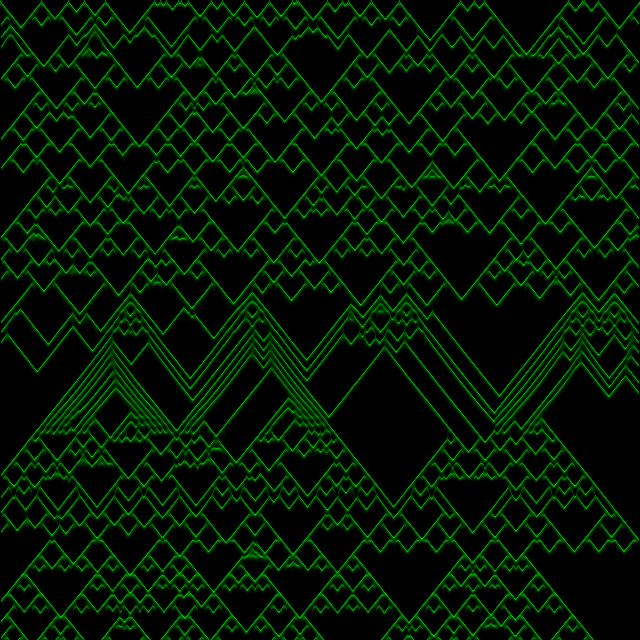

In [25]:
draw_oliva()

In [26]:
with open('sp_pars.json','r') as par_file:
    sp_pars = json.loads(par_file.read())
ext_pars = list(filter(lambda p: p['ke']==711, sp_pars))

conus_nobilis_pars = ext_pars[4]

In [27]:
def draw_conus_nobilis(width=400):
    conus_nobilis = Mollusc(width=width, **conus_nobilis_pars)
    conus_cells = np.stack(list(islice(conus_nobilis, 0, width)))
    img = np.zeros(shape=(width, 2*width, 3))
    left = conus_cells[:,0,:] > 5.0
    left = (255 * left / left.max())
    right = conus_cells[:,5,:]
    right = 255 * right / right.max()
    img[:,0:width,1] = left
    img[:,width:,1] = right
    im_bytes = BytesIO()
    imwrite(im_bytes, img.astype(np.uint8), format='png')
    return display.Image(data=im_bytes.getvalue())

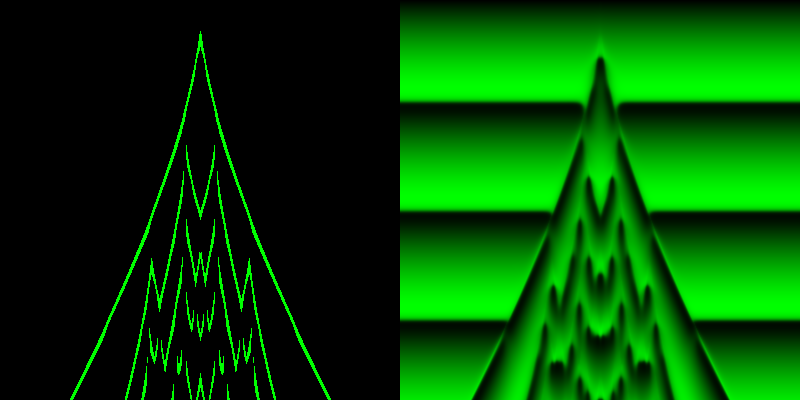

In [28]:
draw_conus_nobilis()

In [29]:
def complex_segment(spectrum, n):
    width = spectrum.shape[1]
    complex_spectrum = spectrum[0,:] + 1j * spectrum[1,:] 
    packed_spectrum = np.zeros(2*width,dtype=np.complex64)
    packed_spectrum[0:width] = complex_spectrum
    packed_spectrum[width:] = np.flip(complex_spectrum.conj(), axis=0)
    return (np.fft.ifft(packed_spectrum,n).real, complex_spectrum.real)

In [30]:
def build_mollusc_frames(shell, dur, N, n , H, segmenter, rate=44100):
    pan_range = np.arange(N)
    frames = dur * rate
    segments = int(frames / H)
    pan = np.zeros(segments)
    frames = n - H + segments * H
    output = np.zeros(frames, dtype=np.float32)
    window = get_window('blackmanharris',n)
    all_segments = map(lambda s: segmenter(s,n), shell)
    with tqdm_notebook(range(segments), desc='building audio', leave=True) as bar:
        for i, seg in enumerate(islice(all_segments,0,segments)):
            signal, spectrum = seg
            pan[i] = np.average(pan_range, weights=spectrum) / N
            start = i * H
            end = start + n
            output[start:end] += window * signal
            bar.update(1)
    pan -= pan.min()
    pan /= pan.max()
    return (output, pan)

In [31]:
def pulse(dur, n, H, rate=44100):
    frames = dur * rate
    segments = int(frames / H)
    width = 2 * segments
    shell = Mollusc(width=width, **conus_nobilis_pars)
    cells = np.stack(list(islice(shell,0,segments)))
    left, _ = build_mollusc_frames(cells[:,0:2,:],dur,width,n,H,complex_segment,rate=rate)
    right, _ = build_mollusc_frames(cells[:,4:6,:],dur,width,n,H,complex_segment,rate=rate)
    return np.vstack([list(left), list(right)]).T

In [32]:
def pan_stereo(data, pan, H, depth, rate=44100):
    scale = 32767.0 / np.max(data)
    floor = 1.0 - depth
    f = UnivariateSpline(np.arange(0,len(data),H)[0:len(pan)], pan)
    pan_interp = f(np.arange(len(data)))
    pan_interp -= pan_interp.min()
    pan_interp /= pan_interp.max()
    pan_interp *= depth
    output = np.zeros((len(data),2))
    output[:,0] = scale * (floor + pan_interp) * data
    output[:,1] = scale * (1.0 - pan_interp) * data
    crossings = np.where(np.diff(np.sign(pan_interp -depth/2)))[0]
    return output, crossings

def write_mono(data, fname, rate=44100):
    scale = 32767.0 / np.max(data) 
    buff = scale * data
    wavfile.write(fname, rate, buff.astype(np.int16))
    
def write_stereo(data, fname, rate=44100):
    scale = 32767.0 / np.max(data)  
    wavfile.write(fname, rate, data.astype(np.int16)) 

In [33]:
mollusc_name = widgets.Text(value='molluscs', placeholder='enter a filename', description='filename')
mollusc_dur = widgets.IntSlider(min=10, max=600, value=120, step=5, description='duration (s)')
mollusc_width = widgets.IntSlider(min=8, max=14, value=10, step=1, description='width')
mollusc_fft = widgets.IntSlider(min=8, max=20, value=15, step=1, description='FFT size')
mollusc_hop = widgets.IntSlider(min=7, max=14, value=11, step=1, description='hop size')
pulse_dur = widgets.IntSlider(min=2, max=20, value=10, step=1, description='pulse dur (s)')
mollusc_button = widgets.Button(description='Build')

def mollusc_sound(b):
    dur = mollusc_dur.value
    width = 2**mollusc_width.value
    fft_size = 2**mollusc_fft.value
    hop = 2**mollusc_hop.value
    conus_dur = pulse_dur.value
    oliva_shell = Oliva(width=width)
    oliva_sound, pan = build_mollusc_frames(oliva_shell, dur, width, fft_size, hop, complex_segment)
    stereo_sound, crossings = pan_stereo(oliva_sound, pan, hop, 0.5)
    conus_width = width // 2
    conus_pulse = pulse(conus_dur,fft_size, conus_width) 
    total_length = max(stereo_sound.shape[0], conus_pulse.shape[0] + crossings[-1])
    output = np.zeros((total_length,2))
    output[0:stereo_sound.shape[0],:] = stereo_sound
    for pos in crossings:
        end = pos + conus_pulse.shape[0]
        output[pos:end] += conus_pulse
    if not os.path.exists('audio'):
        os.makedirs('audio')
    audio_file = '/'.join(['audio', '{}.wav'.format(mollusc_name.value)])
    write_stereo(output, audio_file)
    draw_oliva()
    display.display(display.Audio(filename=audio_file))
    
mollusc_button.on_click(mollusc_sound)

In [34]:
for wdgt in (mollusc_name, mollusc_dur, mollusc_width, mollusc_fft, mollusc_hop, pulse_dur, mollusc_button):
    display.display(wdgt)

Text(value='molluscs', description='filename', placeholder='enter a filename')

IntSlider(value=120, description='duration (s)', max=600, min=10, step=5)

IntSlider(value=10, description='width', max=14, min=8)

IntSlider(value=15, description='FFT size', max=20, min=8)

IntSlider(value=11, description='hop size', max=14, min=7)

IntSlider(value=10, description='pulse dur (s)', max=20, min=2)

Button(description='Build', style=ButtonStyle())

# "Every few months we come across an amateur who, having discovered John Conway's wonderful game of LIFE, feels obliged to present the world with one more computer program to run LIFE simulations or with one more field report on LIFE's 'bestiary' or 'ethology'." 
(Tommaso Toffoli in [A common language for “programmable matter”
(cellular automata and all that), AI*IA, Vol 14, No 2, pg 32, 2001.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.69.3788&rep=rep1&type=pdf))

([Cellular Automata Machines by Toffoli & Margolus](https://people.csail.mit.edu/nhm/cam-book.pdf'))
![Conway](img/conway.png")






In [35]:
def total_2d_ca(rule, kernel, size=512, cells=None, noise=None):
    if cells is None:
        cells = np.random.randint(0, 2, (size,size))
    if noise:
        noise_thresh = int(noise * kernel.sum()/100)
    noise_thresh = None
    while True:
        edges = (abs(laplace(cells, mode='wrap'))>0)
        yield (cells, edges)
        if noise_thresh:
            noise_cells = (np.random.random(edges.sum()) < noise_thresh).astype('int') 
            cells[edges] = np.bitwise_xor(cells[edges], noise_cells)
        cells = rule[convolve(cells, kernel, mode='wrap')]

        
def majority_rule(kernel_size):
    kernel = np.ones((kernel_size, kernel_size), dtype='int')
    rule = (np.arange(1+kernel.size) > (1+kernel.size)//2).astype('int')
    rule[kernel.size//2] = 1
    return kernel, rule


def anneal_rule(kernel_size):
    kernel = np.ones((kernel_size, kernel_size), dtype='int')
    total = kernel.sum()
    rule = np.arange(1+total) > total // 2
    rule[total//2] = not rule[total//2]
    rule[1+total//2] = not rule[1+total//2]
    return kernel, rule.astype('int')
    

In [36]:
ca_step_button = widgets.Button(description='Step')
ca_reset_button = widgets.Button(description='Reset')
total_ca_kernel_slider = widgets.IntSlider(min=3, max=21, value=3, step=2, description='kernel size')
total_ca_noise_slider = widgets.IntSlider(min=0, max=100, value=0, step=1, description='noise%')
ca_rule_radio = widgets.RadioButtons(options=['majority', 'anneal'], description='rule:')

total_ca_im = widgets.Image()
total_ca_edge_im = widgets.Image()

total_ca_controls = widgets.VBox([ca_step_button, ca_reset_button, ca_rule_radio, total_ca_kernel_slider,
    total_ca_noise_slider])
total_ca_box = widgets.HBox([total_ca_im, total_ca_edge_im, total_ca_controls])

class total_ca_app(object):
    rules = {'majority': majority_rule, 'anneal': anneal_rule}
    
    def __init__(self, kernel_slider, noise_slider, rule_radio, ca_image, edge_image, size=320):
        self.kernel_slider = kernel_slider
        self.noise_slider = noise_slider
        self.rule_radio = rule_radio
        self.ca_image = ca_image
        self.edge_image = edge_image
        self.size = size
        self.reset()
        
        
    def reset(self, _=None):
        rule_func = self.rules[self.rule_radio.value]
        self.kernel, self.rule = rule_func(self.kernel_slider.value)
        self.ca = total_2d_ca(self.rule, self.kernel, noise=self.noise_slider.value, size = self.size)
        self.update()

        
    def update(self, _=None):
        cells, edges = self.ca.__next__()
        self.ca_image.value = green_image(cells)
        self.edge_image.value = green_image(edges.astype(np.int16))
    
    
ca_app = total_ca_app(total_ca_kernel_slider, total_ca_noise_slider, ca_rule_radio,
    total_ca_im, total_ca_edge_im)
ca_step_button.on_click(ca_app.update)
ca_reset_button.on_click(ca_app.reset)

In [37]:
display.display(total_ca_box)

In [38]:
def cat_scan(rows, cols):
    grid = np.zeros((len(rows), len(cols)), dtype = np.int16)
    row_sums = np.array(rows)
    col_sums = np.array(cols)
    row_count = np.sum(row_sums>0)
    col_count = np.sum(col_sums>0)
    change = True
    
    while row_count > 0 and change:
        change = False
        
        plot_x = row_sums == col_count
        if plot_x.sum():
            x = np.argwhere(plot_x).flatten()[0]
            row_sums[x] = 0
            plot_y = col_sums > 0
            if plot_y.sum() > 0:
                change = True
            col_sums[plot_y] -= 1
            for y in np.argwhere(plot_y).flatten():
                grid[x,y] = 1
            row_count = np.sum(row_sums>0)
            col_count = np.sum(col_sums>0)
            
        plot_y = col_sums == row_count
        if plot_y.sum():
            y = np.argwhere(plot_y).flatten()[0]
            col_sums[y] = 0
            plot_x = row_sums > 0
            if plot_x.sum() > 0:
                change = True
            row_sums[plot_x] -= 1
            for x in np.argwhere(plot_x).flatten():
                grid[x,y] = 1
            row_count = np.sum(row_sums>0)
            col_count = np.sum(col_sums>0)
    return grid        

In [39]:
def plot_grid(grid):
    cmap = colors.ListedColormap(['white', 'black'])
    norm = colors.BoundaryNorm([0,1,2], cmap.N)
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap=cmap, norm=norm, interpolation='none')
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    h, w = grid.shape
    ax.set_xticks(np.arange(-.5, w, 1));
    ax.set_yticks(np.arange(-.5, h, 1));
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.show()

In [40]:
col_text = widgets.Textarea(value='5, 3, 5, 0, 5, 2, 5, 0, 1, 5, 1',
    placeholder='space/comma separated sums', description='col sums:')

row_text = widgets.Textarea(value='9, 5, 7, 5, 6',
    placeholder='space/cgrideparated sums', description='row sums:')

grid_button = widgets.Button(description='Draw Grid')

def draw_grid(_):
    box_sums = lambda b: list(map(int, filter(None, re.split('[,\s]', b.value))))
    cols = box_sums(col_text)
    rows = box_sums(row_text)
    plot_grid(cat_scan(rows, cols))

grid_button.on_click(draw_grid)
    
cat_box = widgets.HBox([col_text, row_text, grid_button])

# [How to resurrect a cat from its grin](https://www.scientificamerican.com/article/mathematical-recreations-1990-09)
(A. K. Dewdney, Mathematical Recreations, Scientific American, September 1990)

"Here are some categorical patterns to try out on your catscanner. Blending the medical with the recreational for a moment, the following categorical pattern was recently found in a CAT scan of a cat. What had it eaten?

Rows: 9, 5, 7, 5, 6

Columns: 5, 3, 5,0, 5,2, 5,0, 1, 5, 1

Recently someone brought me a box that he could not open, having lost the key. Could I determine the contents of
the box? A cats canner revealed an object with an ambiguous reconstruction, but I immediately knew what it was.

Rows: 11, 5,4

Columns: 3, 2, 3, 1, 1, 1, 1, 2, 3, 2, 1"

See also:
### [Bruno Guerrieri, "Tomographic Reconstruction of 2D Images"](http://ajmonline.org/Spring2007/8.pdf)

In [41]:
display.display(cat_box)

In [42]:
def reconstruction_accuracy(steps, kernel_size, size, noise=None):
    kernel, rule = majority_rule(kernel_size)
    ca = total_2d_ca(rule, kernel, size=size, noise=noise)
    edges = (edge for _, edge in islice(ca, steps))
    reconstructions = (edge==cat_scan(edge.sum(axis=1), edge.sum(axis=0)) for edge in edges)
    total = size * size
    return np.array([rec.sum()/total for rec in reconstructions])

In [43]:
reconstruct_button = widgets.Button(description='Reconstruct')
reconstruct_step_slider = widgets.IntSlider(min=16, max=512, value=64, step=1, description='steps')
reconstruct_kernel_slider = widgets.IntSlider(min=3, max=21, value=9, step=2, description='kernel size')
reconstruct_size_slider = widgets.IntSlider(min=16, max=512, value=64, step=1, description='ca size')
reconstruct_noise_slider = widgets.IntSlider(min=0, max=100, value=0, step=1, description='noise%')

def recconstruct(_):
    steps=reconstruct_step_slider.value
    acc = 100 * reconstruction_accuracy(steps=steps,
        kernel_size=reconstruct_kernel_slider.value, size=reconstruct_size_slider.value,
        noise=reconstruct_noise_slider.value)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    plt.plot(np.arange(steps), acc, color='green')
    ax.set_xlabel('step')
    ax.set_ylabel('reconstruction accuracy')
    plt.show()
    
reconstruct_button.on_click(recconstruct)
    
    
reconstruct_box = widgets.HBox([reconstruct_button, reconstruct_kernel_slider, reconstruct_size_slider,
    reconstruct_noise_slider])

In [44]:
display.display(reconstruct_box)

![all the right noises](img/right_noises.png)

In [45]:
def ca_2d_segment_builder(n, ca):
    for cells, edges in ca:
        r_spectrum = edges.sum(axis=0)
        i_spectrum = edges.sum(axis=1)
        complex_spectrum = r_spectrum + 1j * i_spectrum
        packed_spectrum = np.zeros(2*r_spectrum.size, dtype=np.complex64)
        packed_spectrum[0:r_spectrum.size] = complex_spectrum
        packed_spectrum[r_spectrum.size:] = np.flip(complex_spectrum.conj(),axis=0)
        yield (np.fft.ifft(packed_spectrum,n).real, cells)
        
        
def ca_2d_segment_stack(n, rule, kernel, size=512, noise=None):
    window = get_window('blackmanharris', n).reshape((n,1))
    
    ca1 = total_2d_ca(rule, kernel, size=size, noise=noise)
    ca2 = total_2d_ca(rule, kernel, size=size, noise=noise)
    
    seg1 = ca_2d_segment_builder(n, ca1)
    seg2 = ca_2d_segment_builder(n, ca2)
    
    while True:
        l_seg, im1 = seg1.__next__()
        r_seg, im2 = seg2.__next__()
        
        seg = np.zeros((n,2))
        seg[:,0] = l_seg
        seg[:,1] = r_seg
        
        yield (window * seg, 2 * im1 + im2)

In [46]:
def ca_2d_dump_segments(fname, dur, n, h, rule, kernel, size, noise, video=False, rate = 44100):
    frame_prefix = '/'.join(['frames', fname])
    audio_file = 'audio/{}.wav'.format(fname)
    for direc in ('audio', frame_prefix, 'video'):
        if not os.path.exists(direc):
            os.makedirs(direc)
    frames = dur * rate
    segments = int(frames / h)
    frames = n - h + segments * h    
    output = np.zeros((frames, 2), dtype=np.float32)
    stacks = ca_2d_segment_stack(n, rule, kernel, size=size, noise=noise)
    with tqdm_notebook(range(segments), desc='building frames', leave=True) as bar:
        for i, stack in enumerate(islice(stacks, segments)):
            segment, img = stack     
            if video:
                name = ('000000'+str(i))[-6:]+'.png'
                green_img = np.zeros(shape=(size, size,3), dtype=np.uint8)
                green_img[:,:,1] = (255 * img / img.max()).astype(np.uint8)
                imwrite('/'.join([frame_prefix, name]), green_img.astype(np.uint8), format='png')
            start = i * h
            end = start + n
            output[start:end] += segment
            bar.update(1)
    scale = 32767.0 / np.max(np.abs(output))
    wavfile.write(audio_file, rate, (scale*output).astype(np.int16))
    display.display(display.Audio(filename=audio_file))
    if video:
        video_file = 'video/{}.mp4'.format(fname)
        args = ['ffmpeg', '-i', '{}/%06d.png'.format(frame_prefix), '-i',
            audio_file, '-c:v', 'libx264', '-acodec', 'libmp3lame', '-r', '24',
            '-pix_fmt', 'yuv420p', video_file]
        subprocess.run(args)
        display.display(widgets.Video.from_file(video_file))
    

In [47]:
anneal_dur_slider = widgets.IntSlider(min=10, max=600, value=120, step=5, description='duration (s)')
anneal_noise_slider = widgets.IntSlider(min=0, max=100, value=37, step=1, description='noise%')
anneal_kernel_slider = widgets.IntSlider(min=3, max=31, value=23, step=2, description='kernel size')
anneal_size_slider = widgets.IntSlider(min=320, max=800, value=512, step=1, description='ca size')
anneal_fft_slider = widgets.IntSlider(min=10, max=16, value=15, step=1, description='FFT size')
anneal_hop_slider = widgets.IntSlider(min=7, max=14, value=11, step=1, description='hop size')
anneal_build_video = widgets.RadioButtons(options=['off', 'on'], value='off', description='build video')
anneal_build_button = widgets.Button(description='Build')


def anneal_ca(_):
    dur = anneal_dur_slider.value
    noise = anneal_noise_slider.value
    kernel_size = anneal_kernel_slider.value
    size = anneal_size_slider.value
    n = 2**anneal_fft_slider.value
    h = 2**anneal_hop_slider.value
    fname = 'anneal_{}_{}_{}'.format(kernel_size, size, noise)
    build_video = anneal_build_video.value == 'on'
    if build_video:
        rate = 48000
    else:
        rate = 44100
    kernel, rule = majority_rule(kernel_size)
    ca_2d_dump_segments(fname, dur, n, h, rule, kernel, size, noise, video=build_video, rate = rate)

anneal_build_button.on_click(anneal_ca)    
    
anneal_box = widgets.VBox([
    widgets.HBox([anneal_dur_slider, anneal_noise_slider]),
    widgets.HBox([anneal_kernel_slider, anneal_size_slider]),
    widgets.HBox([anneal_fft_slider, anneal_hop_slider]), 
    widgets.HBox([anneal_build_button, anneal_build_video])])

In [48]:
display.display(anneal_box)